In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import shapiro, normaltest, mannwhitneyu, chi2_contingency
from statsmodels.stats.proportion import proportions_ztest

np.random.seed(42)

In [61]:
# Количество пользователей
n = 5000

# Генерируем данные
user_id = np.arange(1, n+1)  # user_id от 1 до n
groups = np.random.choice(['A', 'B'], size=n)  # Случайно распределяем пользователей по группам A и B
button_colors = np.where(groups == 'A', 'Красная', 'Синяя')  # В группе A красная кнопка, в группе B синяя

# Симулируем просмотр страницы товара (все пользователи видят страницу)
page_viewed = np.ones(n)

# Симулируем покупку: с вероятностью 0.55 для A и 0.50 для B
purchase_probabilities = np.where(groups == 'A', 0.55, 0.50)
purchase_made = np.random.binomial(1, purchase_probabilities)  # 1 - покупка, 0 - нет

# Генерируем сумму заказа, если покупка была сделана (иначе 0)
order_values = np.where(purchase_made == 1, np.random.randint(1000, 50000, size=n), 0)


# Даты начала и окончания теста
test_start_date = pd.to_datetime('2024-06-01')
test_end_date = pd.to_datetime('2024-06-21')

# Создаем DataFrame
df = pd.DataFrame({
    'user_id': user_id,
    'group': groups,
    'button_color': button_colors,
    'page_viewed': page_viewed,
    'purchase_made': purchase_made,
    'order_value': order_values,
    'test_start_date': test_start_date,
    'test_end_date': test_end_date
})

# Просмотр первых 10 строк данных
df.head()

# Сохраняем данные в CSV
# df.to_csv('ab_test_button_data.csv', index=False)

,user_id,group,button_color,page_viewed,purchase_made,order_value,test_start_date,test_end_date
0,1,B,Синяя,1.0,1,34436,2024-06-01,2024-06-21
1,2,A,Красная,1.0,0,0,2024-06-01,2024-06-21
2,3,A,Красная,1.0,0,0,2024-06-01,2024-06-21
3,4,B,Синяя,1.0,1,1160,2024-06-01,2024-06-21
4,5,A,Красная,1.0,1,44358,2024-06-01,2024-06-21


Постановка задачи:
На сайте изменили цвет кнопки заказа с красной на синюю. Определить, какая кнопка оказалась эффективнее.

In [127]:
group_A = df.query('group == "A"')
group_B = df.query('group == "B"')

In [128]:
group_A_purchase = group_A.query('purchase_made == 1') # Совершенные заказы группы А
group_B_purchase = group_B.query('purchase_made == 1') # Совершенные заказы группы В

Нулевая гипотеза - Новая кнопка (группа В) не влияет, или работает хуже группы А. 

Альтернативная гипотеза - Новая кнопка (группа В) работает лучше.

# Metrics

## average purchase price

In [129]:
average_a = group_A_purchase.order_value.mean()

In [130]:
average_b = group_B_purchase.order_value.mean()

In [131]:
print(f"Средняя стоимость покупки группы A: {average_a:.2f}")
print(f"Средняя стоимость покупки группы B: {average_b:.2f}")

Средняя стоимость покупки группы A: 24904.23
Средняя стоимость покупки группы B: 25237.70


## conversion

In [102]:
conversion_a = sum(group_A_purchase.purchase_made) / len(group_A)

In [104]:
conversion_b = sum(group_B_purchase.purchase_made) / len(group_B)

In [105]:
print(f"Конверсия группы A: {conversion_a * 100:.2f}%")
print(f"Конверсия группы B: {conversion_b * 100:.2f}%")

Конверсия группы A: 55.03%
Конверсия группы B: 48.04%


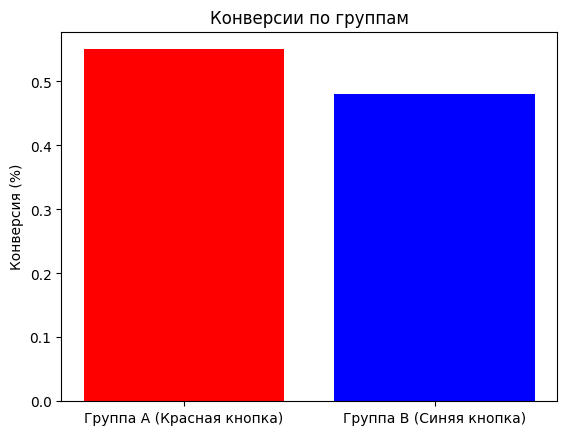

In [81]:
# Построение bar plot
conversions = [conversion_a, conversion_b]
labels = ['Группа A (Красная кнопка)', 'Группа B (Синяя кнопка)']

plt.bar(labels, conversions, color=['red', 'blue'])
plt.title('Конверсии по группам')
plt.ylabel('Конверсия (%)')
plt.show()

# Сheck the data for normal distribution

## draw a histogram and QQ-plot

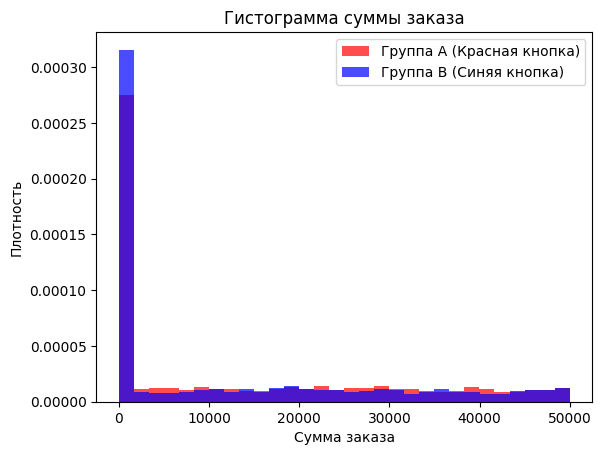

In [89]:
group_a = group_A.order_value
group_b = group_B.order_value

# Гистограмма для группы A
plt.hist(group_a, bins=30, alpha=0.7, label='Группа A (Красная кнопка)', color='red', density=True)

# Гистограмма для группы B
plt.hist(group_b, bins=30, alpha=0.7, label='Группа B (Синяя кнопка)', color='blue', density=True)


plt.title('Гистограмма суммы заказа')
plt.xlabel('Сумма заказа')
plt.ylabel('Плотность')
plt.legend()
plt.show()

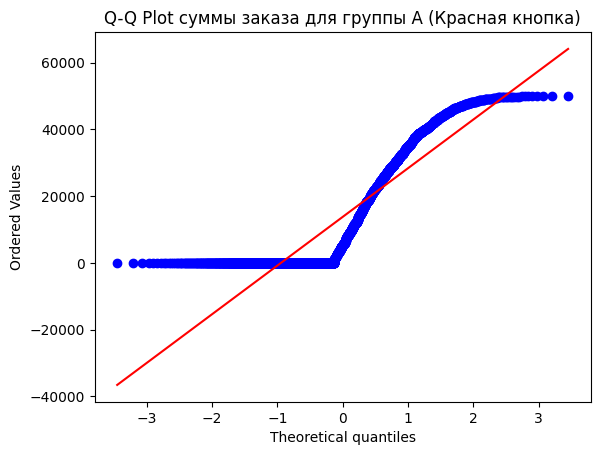

In [97]:
stats.probplot(group_a, dist="norm", plot=plt)
plt.title("Q-Q Plot суммы заказа для группы A (Красная кнопка)")
plt.show()

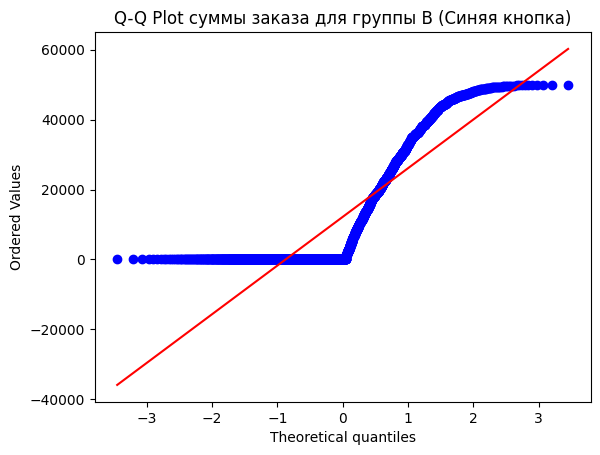

In [98]:
stats.probplot(group_b, dist="norm", plot=plt)
plt.title("Q-Q Plot суммы заказа для группы B (Синяя кнопка)")
plt.show()

Исходя из гистограммы и QQ-plot первично можно сделать вывод, что распределение в группах не соотвествует нормальному.
На гистограмме в обоих группах видно, что график слева сильно преобладает в нуле. Это характерно для денежных данных, так как для покупателей, которые не совершали покупок, значение переменной равно 0.

QQ-plot также подтверждает эти выводы, в нормальном распределении синяя линяя должна лежать на красной, либо с небольшим смещением от нее.

Проведем тесты на нормальность распределения для конечного вывода.

# Tests

## Shapiro-Wilk test

### Group A

In [111]:
stat_a, p_a = shapiro(group_a)
print(f"Statistic: {stat_a}, p-value: {p_a}")
if p_a > 0.05:
    print("Распределение нормальное")
else:
    print("Распределение ненормальное")

Statistic: 0.8025902180699194, p-value: 4.911895175224245e-48
Распределение ненормальное


### Group B

In [112]:
stat_b, p_b = shapiro(group_b)
print(f"Statistic: {stat_b}, p-value: {p_b}")
if p_b > 0.05:
    print("Распределение нормальное")
else:
    print("Распределение ненормальное")

Statistic: 0.7618659969345194, p-value: 4.518378128406426e-51
Распределение ненормальное


## D’Agostino and Pearson’s test

### Group A 

In [113]:
stat_a_nt, p_a_nt = normaltest(group_a)
print(f"Statistic: {stat_a_nt}, p-value: {p_a_nt}")
if p_a_nt > 0.05:
    print("Распределение нормальное")
else:
    print("Распределение ненормальное")

Statistic: 446.75852906572175, p-value: 9.718920771368068e-98
Распределение ненормальное


### Group B 

In [114]:
stat_b_nt, p_b_nt = normaltest(group_b)
print(f"Statistic: {stat_b_nt}, p-value: {p_b_nt}")
if p_b_nt > 0.05:
    print("Распределение нормальное")
else:
    print("Распределение ненормальное")

Statistic: 327.06354887739496, p-value: 9.529118889384164e-72
Распределение ненормальное


Критерии Шапиро-Уилка и Д'Агостино показали, что распределение стоимости сумм заказов является ненормальным. 
Исходя из этого, для проверки гипотез будем использовать непараметрические тесты, например, Манна-Уитни.

## Mann-Whitneyu test

In [136]:
order_value_purchase_a = group_A_purchase.order_value
order_value_purchase_b = group_B_purchase.order_value

In [140]:
stat_mw, p_value_mw = mannwhitneyu(order_value_purchase_a, order_value_purchase_b, alternative='greater')

In [150]:
print(f"U-статистика: {stat_mw:.3f}, p-value: {p_value_mw:.5f}")
if p_value_mw < 0.05:
    print("Средний чек группы B значимо больше среднего чека группы А.")
else:
    print("Нет значимых различий в среднем чеке между группами.")

U-статистика: 879087.500, p-value: 0.73031
Нет значимых различий в среднем чеке между группами.


## Z-test

In [149]:
purchase_a = group_A.purchase_made.sum()
size_a = group_A.purchase_made.count()

purchase_b = group_B.purchase_made.sum()
size_b = group_B.purchase_made.count()

In [152]:
stat_z, p_value_z = proportions_ztest([purchase_a, purchase_b], [size_a, size_b], alternative='larger')

In [155]:
print(f"Z-статистика: {stat_z:.3f}, p-value: {p_value_z:.5f}")
if p_value_z < 0.05:
    print("Конверсия группы B значимо выше конверсии группы А.")
else:
    print("Нет значимых различий в конверсии между группами.")

Z-статистика: 1.578, p-value: 0.05729
Нет значимых различий в конверсии между группами.


## Chi-2 test

In [156]:
frequency_table = [
    [purchase_a, size_a - purchase_a],
    [purchase_b, size_b - purchase_b]
]

In [158]:
chi2, p_value_chi2, dof, expected = chi2_contingency(frequency_table)

In [159]:
print(f"Хи-квадрат: {chi2:.3f}, p-value: {p_value_chi2:.5f}")
if p_value_chi2 < 0.05:
    print("Конверсия группы B значимо выше конверсии группы А.")
else:
    print("Нет значимых различий в конверсии между группами.")

Хи-квадрат: 2.401, p-value: 0.12124
Нет значимых различий в конверсии между группами.


В результате проведенных статистических тестов было выявлено, что изменение кнопки заказа с красной (группа А) на синюю (группы В) не привело к статистически значимым изменениям в стоимости среднего чека и конверсии.

Рекомендуется продолжить сбор данных и провести дополнительные тесты для подтверждения результатов.